In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
    pass

# matplotlib rendering
%matplotlib inline

import sys
sys.path.append("../") # go to parent dir -> for module loading

TensorFlow 2.x selected.


In [20]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import backend as K

# custom modules
import data_manager
import model

print('Tensorflow version:', tf.__version__)
print('GPU support:', tf.test.is_gpu_available())

# set all keras layers to use float64
tf.keras.backend.set_floatx('float64')

Tensorflow version: 2.1.0-rc1
GPU support: True


In [3]:
!wget pollithy.com/DEM_Cylinder_115.zip
!unzip DEM_Cylinder_115.zip

--2020-01-26 10:23:57--  http://pollithy.com/DEM_Cylinder_115.zip
Resolving pollithy.com (pollithy.com)... 87.118.94.85
Connecting to pollithy.com (pollithy.com)|87.118.94.85|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://pollithy.com/DEM_Cylinder_115.zip [following]
--2020-01-26 10:23:58--  https://pollithy.com/DEM_Cylinder_115.zip
Connecting to pollithy.com (pollithy.com)|87.118.94.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2684430 (2.6M) [application/zip]
Saving to: ‘DEM_Cylinder_115.zip’

DEM_Cylinder_115.zi 100%[===================>]   2.56M  1.32MB/s    in 1.9s    

2020-01-26 10:24:01 (1.32 MB/s) - ‘DEM_Cylinder_115.zip’ saved [2684430/2684430]

Archive:  DEM_Cylinder_115.zip
  inflating: DEM_cylinder.csv        


timesteps=1999
longest_track=49
align data
longest_track= 49


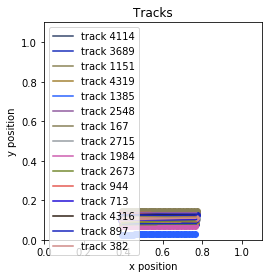

In [4]:
nan_value = 0
batch_size = 64

csv_data_set = data_manager.CsvDataSet('DEM_cylinder.csv',
                                       nan_value=nan_value, 
                                       batch_size=batch_size, 
                                       data_is_aligned=False,
                                       rotate_columns=True,
                                       normalization_constant=1)

csv_data_set.plot_random_tracks(n=15)

In [0]:
dataset_train, dataset_test = csv_data_set.get_tf_data_sets_seq2seq_data(normalized=True)

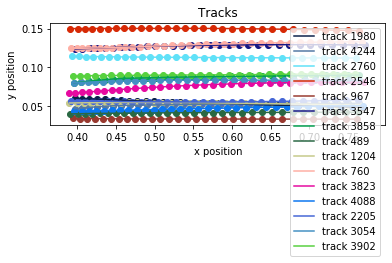

In [7]:
csv_data_set.plot_random_tracks(n=15, fit_scale_to_content=True)

In [24]:
rnn_model, hash_ = model.rnn_model_factory(
        num_units_first_rnn=1024, 
        num_units_second_rnn=16,
        num_units_first_dense=0,
        rnn_model_name='lstm',
        num_time_steps=csv_data_set.longest_track, 
        batch_size=batch_size,
        nan_value=nan_value, 
        input_dim=2)
print(rnn_model.summary())

optimizer = tf.keras.optimizers.Adam()
train_step_fn = model.train_step_generator(rnn_model, optimizer)

total_num_epochs = 1000

for epoch in range(total_num_epochs):
  if (epoch+1) % 80 == 0:
      old_lr = K.get_value(optimizer.lr)
      new_lr = old_lr * 0.1
      print("Reducing learning rate from {} to {}.".format(old_lr, new_lr))
      K.set_value(optimizer.lr, new_lr)

  for (batch_n, (inp, target)) in enumerate(dataset_train):
      _ = rnn_model.reset_states()
      loss = train_step_fn(inp, target)

  print("{}/{}: \t loss={}".format(epoch, total_num_epochs, loss))


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_layer (Masking)      (64, 49, 2)               0         
_________________________________________________________________
rnn-0 (LSTM)                 (64, 49, 1024)            4206592   
_________________________________________________________________
rnn-1 (LSTM)                 (64, 49, 16)              66624     
_________________________________________________________________
dense (Dense)                (64, 49, 2)               34        
Total params: 4,273,250
Trainable params: 4,273,250
Non-trainable params: 0
_________________________________________________________________
None
0/1000: 	 loss=0.004062928777731178
1/1000: 	 loss=0.0023201383241764064
2/1000: 	 loss=0.0016108980638174866
3/1000: 	 loss=0.0012159832551724328
4/1000: 	 loss=0.0009863285336599212
5/1000: 	 loss=0.0007391904270019741
6/1000: 	 loss=0.0

KeyboardInterrupt: ignored

In [0]:
rnn_model.save('DEM_model.h5')

In [0]:
maes = np.array([])

mask_value = K.variable(np.array([nan_value, nan_value]), dtype=tf.float64)
normalization_factor = csv_data_set.belt_width

for input_batch, target_batch in dataset_test:
    # reset state
    hidden = rnn_model.reset_states()

    batch_predictions = rnn_model(input_batch)

    # Calculate the mask
    mask = K.all(K.equal(target_batch, mask_value), axis=-1)
    mask = 1 - K.cast(mask, tf.float64)
    mask = K.cast(mask, tf.float64)

    target_batch_unnormalized = target_batch * normalization_factor
    pred_batch_unnormalized = batch_predictions * normalization_factor

    batch_loss = tf.keras.losses.mean_absolute_error(target_batch_unnormalized, pred_batch_unnormalized) * mask
    
    num_time_steps_per_track = tf.reduce_sum(mask, axis=-1)
    
    batch_loss_per_track = tf.reduce_sum(batch_loss, axis=-1) / num_time_steps_per_track

    maes = np.concatenate((maes, batch_loss_per_track.numpy().reshape([-1])))



In [27]:
print("Mean={}".format(np.mean(maes)))

Mean=0.0003810550153294183


In [0]:
maes_millimeter = maes * 1000.
maes_px = maes_millimeter * (1. / 0.056)

In [29]:
print("Mean[px]={}".format(np.mean(maes_px)))

Mean[px]=6.804553845168184


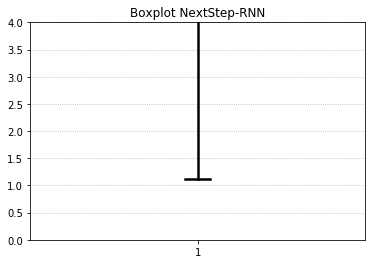

In [33]:
plt.rc('grid', linestyle=":")
fig1, ax1 = plt.subplots()
ax1.yaxis.grid(True)
ax1.set_ylim([0,4.0])
  
ax1.set_title('Boxplot NextStep-RNN')
prop = dict(linewidth=2.5)
ax1.boxplot(maes_px, showfliers=False, boxprops=prop, whiskerprops=prop, medianprops=prop, capprops=prop)
plt.show()

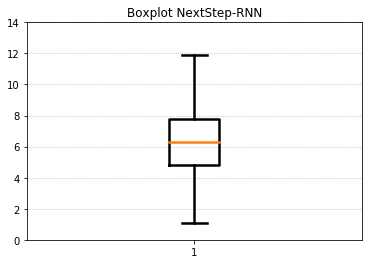

In [34]:
plt.rc('grid', linestyle=":")
fig1, ax1 = plt.subplots()
ax1.yaxis.grid(True)
ax1.set_ylim([0,14.0])
  
ax1.set_title('Boxplot NextStep-RNN')
prop = dict(linewidth=2.5)
ax1.boxplot(maes_px, showfliers=False, boxprops=prop, whiskerprops=prop, medianprops=prop, capprops=prop)
plt.show()